### Imports

In [21]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

### Data

In [80]:
data = np.array([0])

### Loss function

In [81]:
def L(data):
    return data

### Kernel

In [82]:
N = 3
@qml.qnode(qml.device("default.qubit", wires=N))
def k(x, y):
    for n in range(N):
        qml.RX(x, wires=n)
        qml.adjoint(qml.RX(y, wires=n))
    
    observable = qml.s_prod(1/2, qml.sum(*[
        qml.Identity(wires=range(N)),
        qml.prod(*[qml.PauliZ(wires=i) for i in range(N)])
        ])
    )
    return qml.expval(observable)

In [83]:
print(qml.draw(k)(np.pi/4, np.pi/2))

0: ──RX(0.79)──RX(1.57)†─┤ ╭<0.50*I+(Z@Z@Z)>
1: ──RX(0.79)──RX(1.57)†─┤ ├<0.50*I+(Z@Z@Z)>
2: ──RX(0.79)──RX(1.57)†─┤ ╰<0.50*I+(Z@Z@Z)>


In [116]:
def U(x, N):
    qc = QuantumCircuit(N, name="U")
    for n in range(N):
        qc.rx(x, n)
    return qc

def U_dagger(x, N):
    qc = QuantumCircuit(N, name="$U^\dagger$")
    for n in range(N):
        qc.rx(-x, n)
    return qc

def kernel_circuit(N):
    qc = QuantumCircuit(N, name="$\kappa$")
    x = Parameter("x")
    y = Parameter("y")

    qc.append(U(y, N), range(N))
    qc.append(U_dagger(x, N), range(N))

    qc.measure_all()
    return qc

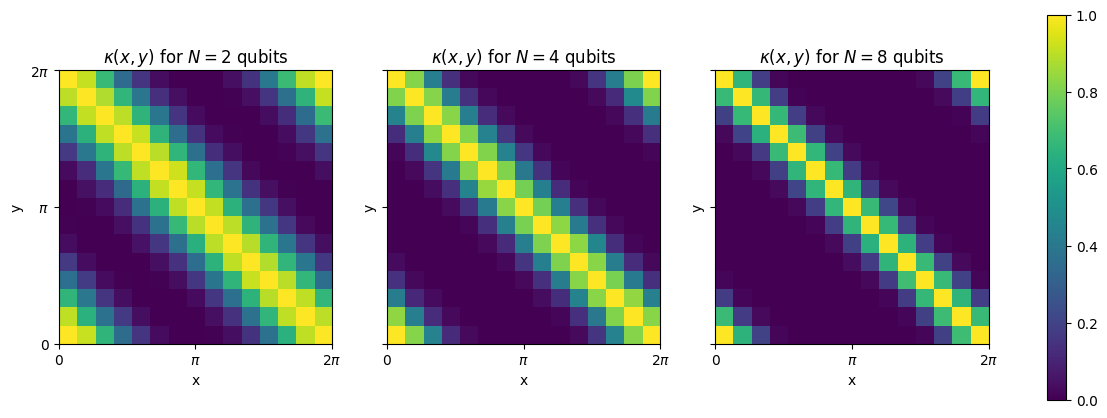

In [135]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler


def K(N):
    def k(x, y):
        n_shots = 1024
        sampler = StatevectorSampler()
        circuit = kernel_circuit(N)

        # Transpile circuit
        pm = generate_preset_pass_manager(optimization_level=1)
        pm.run(circuit)

        # Run using V2 sampler
        result = sampler.run([(circuit, [x, y])], shots=n_shots).result()

        # Access result data for PUB 0
        data_pub = result[0].data
        counts = data_pub.meas.get_counts()

        # Calculate the probability of the all zeros state
        all_zeros = '0' * N
        if all_zeros not in counts:
            return 0
        return counts[all_zeros] / n_shots
    
    return k


def kernel_subplot(ax, N, grid_res=15):
    xs = np.linspace(0, 2*np.pi, grid_res)
    k = K(N)
    KK = np.array([[k(x, y) for x in xs] for y in xs])

    ax.set_title(f"$\kappa(x, y)$ for $N={N}$ qubits")
    ax.imshow(KK, extent=(0, 2*np.pi, 0, 2*np.pi))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", "$\pi$", "$2\pi$"])
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", "$\pi$", "$2\pi$"])


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
kernel_subplot(axs[0], 2)
kernel_subplot(axs[1], 4)
kernel_subplot(axs[2], 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

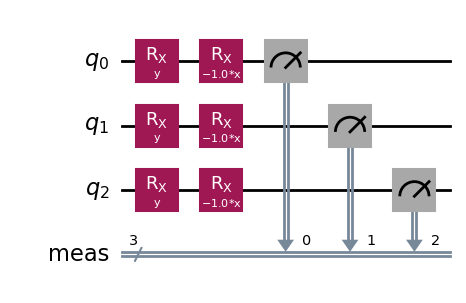

In [141]:
qc = kernel_circuit(3)
qc.decompose().draw(output='mpl', plot_barriers=False,fold=-1)

In [148]:
@qml.qnode(qml.device("default.qubit", wires=3))
def circuit():
    # Since measurements=None, the measurements present in the QuantumCircuit are returned.
    measurements = qml.from_qiskit(qc)(np.pi, np.pi/2)
    return [qml.expval(m) for m in measurements]

# Draw
print(qml.draw(circuit)())

0: ─╭||──┤↗├───────────┤       
1: ─├||───║───┤↗├──────┤       
2: ─╰||───║────║───┤↗├─┤       
          ╚════║════║══╡  <MCM>
               ╚════║══╡  <MCM>
                    ╚══╡  <MCM>


/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.9/site-packages/pennylane_qiskit/converter.py:535: UserWarning: pennylane_qiskit.converter: The Instruction instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(
